# DS-CASE-STUDY-2

## What is churn? 

Churn = A member is considered churned if they have no transactions for the next 3 months

## Prediction Goal

Predict which active members today are likely to churn in the next 3 months (i.e., become inactive).
Use this prediction to proactively target these members with retention campaigns.

## Evaluation Approach
Binary classification problem (churned vs. active)
Use AUC-ROC, precision-recall, and F1 score for model evaluation, focusing on identifying true churners.

In [5]:
import pandas as pd
import numpy as np
from datetime import timedelta

# Load data
base_path = r"C:\Users\Fadhlan\Desktop\data-takehome-fadhlan\data\\"
members = pd.read_csv(base_path + "members.csv", parse_dates=['signup_date'])
transactions = pd.read_csv(base_path + "transactions.csv", parse_dates=['timestamp'])
engagement = pd.read_csv(base_path + "engagement.csv")

In [6]:
# Define the churn cutoff date (latest transaction date - 3 months)
last_txn_date = transactions['timestamp'].max()
churn_cutoff = last_txn_date - pd.DateOffset(months=3)

# Label churn: 1 if no transaction in the last 3 months, else 0
recent_txn = transactions[transactions['timestamp'] > churn_cutoff]
active_member_ids = set(recent_txn['member_id'])
members['churned'] = ~members['member_id'].isin(active_member_ids)
members['churned'] = members['churned'].astype(int)


In [7]:
# Aggregate transaction features
txn_agg = transactions.groupby('member_id').agg(
    total_spend=('spend_amount', 'sum'),
    mean_spend=('spend_amount', 'mean'),
    txn_count=('spend_amount', 'count'),
    last_txn=('timestamp', 'max'),
    first_txn=('timestamp', 'min')
).reset_index()

# Create time-based features
txn_agg['recency_days'] = (last_txn_date - txn_agg['last_txn']).dt.days
#txn_agg['tenure_days'] = (txn_agg['last_txn'] - txn_agg['first_txn']).dt.days
#txn_agg['last_txn_month'] = txn_agg['last_txn'].dt.month
txn_agg['recent_activity'] = (txn_agg['recency_days'] <= 30).astype(int)


In [8]:
# Merge all data
df = members.merge(txn_agg, on='member_id', how='left')
df = df.merge(engagement, on='member_id', how='left')
df = df.fillna(0)  # Fill missing values with 0


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report

# Prepare features (drop ID, date, and churn label)
X = df.drop(['member_id', 'signup_date', 'churned'], axis=1)
# Drop datetime columns not suitable for ML models
X = X.drop(['last_txn', 'first_txn', 'recent_activity'], axis=1)
# One-hot encoding for categorical variables
X = pd.get_dummies(X, columns=['tier', 'age_group', 'state'], drop_first=True)
y = df['churned']


In [12]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


ROC AUC: 1.0
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        77
           1       1.00      0.96      0.98        23

    accuracy                           0.99       100
   macro avg       0.99      0.98      0.99       100
weighted avg       0.99      0.99      0.99       100



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


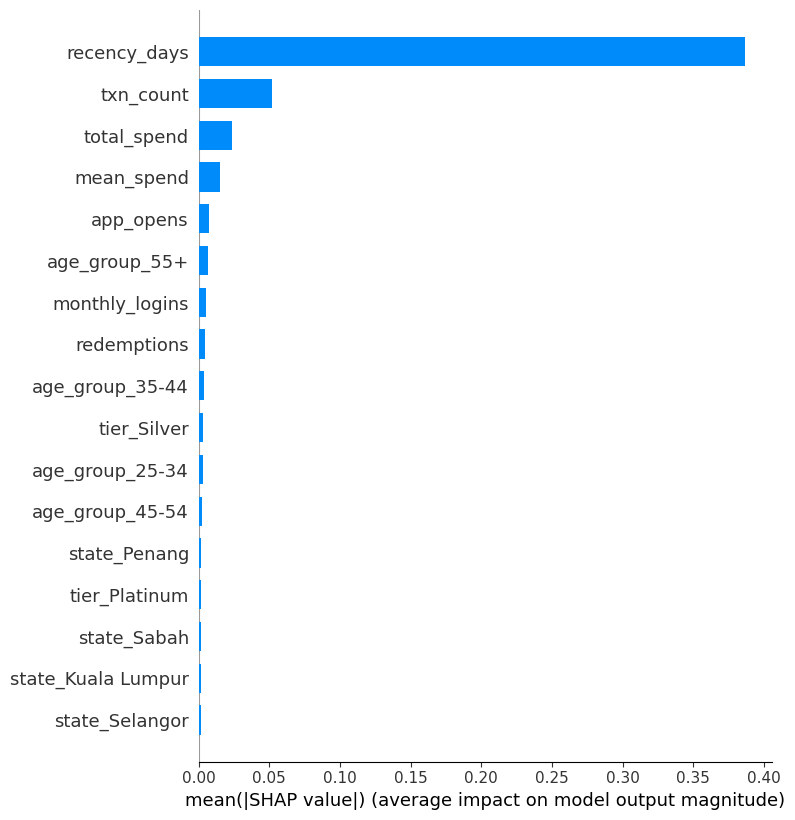

In [15]:
import shap

# Use real feature names for SHAP plot
feature_names = X.columns.tolist()
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# SHAP feature importance
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_df)
shap.summary_plot(shap_values[1], X_test_df, plot_type='bar')


# Key Features Influencing Churn

 Recency: Members who haven't transacted recently are more likely to churn.
 Engagement: Low app usage, logins, or redemptions signal higher churn risk.
 Spending behavior: Low or infrequent spending indicates disengagement.

## Business Actions

-Target high-risk members with special offers, reminders, or personalized campaigns.
-Encourage engagement (e.g., app push notifications, reward reminders to the customers).
-Consider onboarding journeys for new members to increase initial engagement.

-By focusing on at-risk members highlighted by the model, BonusLink can increase retention and drive more value from its member base.
